# 01_experiments_dev — MVTec 画像異常検知（開発

本ノートは dev カテゴリのみで設計を確定し、固定パイプライン設定を `assets/fixed_pipeline.json` に出力するためのテンプレートです。
- データ取得は anomalib を用いる（AGENTS.md 準拠）
- 手法は Mahalanobis / PaDiM を比較
- 閾値は dev の test で画像レベル FPR=1% を目標に決定

実行順序：Header → Data → Methods → Results → Save JSON/Artifacts


## 環境・依存の読み込み

In [1]:
import warnings
warnings.filterwarnings('ignore')  # すべての警告を非表示

In [2]:
# 参考: anomaly_detection.ipynb からの初期インポートを整理
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from sklearn.covariance import ledoit_wolf
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.express as px
from torch import nn
import torch.nn.functional as F

# anomaly_detectors からコア関数をインポート
from anomaly_detectors import (
    fit_mahalanobis, all_mahalanobis_scores,
    fit_padim, padim_heatmap, all_padim_scores,
)

## データ取得（anomalib 経由）

In [3]:
# AGENTS.md: 既存の MVTEC_ROOT または datasets/MVTecAD を使用。
# 未検出の場合は anomalib によりダウンロード。
MVTEC_ROOT = Path(os.environ.get("MVTEC_ROOT", "datasets/MVTecAD"))
MVTEC_ROOT.mkdir(parents=True, exist_ok=True)

# anomalib のAPIはバージョンで異なる可能性があるため、例示的に記述。
# 実環境の anomalib バージョンに合わせて import と引数を調整してください。
try:
    from anomalib.data import MVTecAD
    datamodule = MVTecAD(root=str(MVTEC_ROOT))
    datamodule.prepare_data()  # download if needed
    datamodule.setup()
except Exception as e:
    print("[WARN] anomalib のデータ取得セットアップで問題が発生しました。バージョンや引数を確認してください:\n", e)

assert MVTEC_ROOT.exists(), "MVTec root not found after anomalib setup."


## 実験設定

In [4]:
# dev カテゴリと seed を定義
dev_category = "carpet"  # 例: AGENTS.md 推奨例
seeds = [0, 1, 2]
image_size = 256

# 比較する手法（最小構成）
#use_mahalanobis = True
#use_padim = True

# PaDiM や Mahalanobis で用いる backbone/layers 等は仮パラメータ（要調整）
backbone = "efficientnet_b0"
# モデル本体（新旧API両対応）
try:
    from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).eval()
except Exception:
    model = models.efficientnet_b0(pretrained=True).eval()
padim_layers = ['features.7.0.block.0', 'features.7.0.block.1', 'features.7.0.block.2', 'features.7.0.block.3']
# efficientnet:['features.6.3.add', 'features.7.0.block.0', 'features.7.0.block.1', 'features.7.0.block.2', 'features.7.0.block.3', 'features.8']
# resnet:["layer1", "layer2", "layer3"]
padim_channel_subsample = 100
#cov_estimator = "ledoit_wolf"  # Mahalanobis 用


## 学習と推論
- 各手法で dev の train を用いたクロスバリデーションを実施し、訓練内/訓練外スコアのヒストグラムを確認する。
- dev の test で閾値と評価指標（AUROC, F1 など）の関係を可視化する。


### データローダー準備

In [5]:
# Data loading for cross-validation (dev train) and dev test
# - Builds KFold train/val DataLoaders using only train/good images.
# - Prepares dev test DataLoader with labels (good=0, defect=1).

from pathlib import Path
from typing import List, Tuple, Any
from PIL import Image
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset
import os

# Transforms (ImageNet mean/std)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

class ImagePathDataset(Dataset):
    """Minimal dataset returning (image_tensor, label).

    Paths: list of filesystem paths; Labels: list[Any] of same length.
    """
    def __init__(self, paths: List[Path], labels: List[Any], transform=None):
        self.paths = [Path(p) for p in paths]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(p).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, y

def _existing_category_root(category: str) -> Path:
    """Find an existing MVTec category root among common layouts.
    Prefers MVTEC_ROOT, then 'datasets/MVTecAD', then 'MVtec_dataset'.
    """
    candidates = [
        MVTEC_ROOT / category,
        Path("datasets/MVTecAD") / category,
        Path("MVtec_dataset") / category,
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError(f"MVTec category not found: {category}")

def _list_images(d: Path) -> List[Path]:
    exts = {".png", ".jpg", ".jpeg"}
    if not d.exists():
        return []
    return sorted([p for p in d.rglob('*') if p.suffix.lower() in exts])

def build_cv_and_test_loaders(category: str, k_splits: int = 5, batch_size: int = 32) -> Tuple[list, DataLoader]:
    """Return (cv_folds, test_loader).

    cv_folds: list of dicts with 'train_loader' and 'val_loader'.
    test_loader: dev test DataLoader with labels equal to defect types
                 (the directory names directly under 'test', e.g., 'good',
                 'scratch', 'hole', ...).
    """
    root = _existing_category_root(category)
    train_good = _list_images(root / 'train' / 'good')
    assert len(train_good) > 0, f"No train/good images found for {category}"

    # Prepare KFold over indices (all labels are 0 in train).
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=seeds[0] if seeds else 0)
    base_ds = ImagePathDataset(train_good, [0] * len(train_good), transform=_transform)

    num_workers = min(4, os.cpu_count() or 1)
    cv_folds = []
    for fold_id, (tr_idx, va_idx) in enumerate(kf.split(range(len(train_good)))):
        tr_ds = Subset(base_ds, tr_idx)
        va_ds = Subset(base_ds, va_idx)
        tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        cv_folds.append({
            'fold': fold_id,
            'train_loader': tr_loader,
            'val_loader': va_loader,
            'n_train': len(tr_idx),
            'n_val': len(va_idx),
        })

    # Build dev test loader with labels as defect types (dir names under 'test').
    test_dir = root / 'test'
    test_paths: List[Path] = []
    test_labels: List[str] = []
    if test_dir.exists():
        # Iterate over subdirectories directly under 'test' (including 'good').
        for sub in sorted([d for d in test_dir.iterdir() if d.is_dir()], key=lambda p: p.name):
            label = sub.name  # defect type (or 'good')
            paths = _list_images(sub)
            if paths:
                test_paths.extend(paths)
                test_labels.extend([label] * len(paths))
    assert len(test_paths) > 0, f"No test images found for {category}"

    test_ds = ImagePathDataset(test_paths, test_labels, transform=_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return cv_folds, test_loader

# Build loaders for the chosen dev category
cv_folds, dev_test_loader = build_cv_and_test_loaders(dev_category, k_splits=5, batch_size=32)
print(f"[INFO] Category: {dev_category}")
print(f"[INFO] CV folds: {len(cv_folds)}")
for f in cv_folds:
    print(f"  - fold {f['fold']}: n_train={f['n_train']}, n_val={f['n_val']}")
from collections import Counter
cnt = Counter(dev_test_loader.dataset.labels)
print(f"[INFO] Dev test size: {len(dev_test_loader.dataset)}")
print(f"[INFO] Test label distribution: {dict(cnt)}")


[INFO] Category: carpet
[INFO] CV folds: 5
  - fold 0: n_train=224, n_val=56
  - fold 1: n_train=224, n_val=56
  - fold 2: n_train=224, n_val=56
  - fold 3: n_train=224, n_val=56
  - fold 4: n_train=224, n_val=56
[INFO] Dev test size: 117
[INFO] Test label distribution: {'color': 19, 'cut': 17, 'good': 28, 'hole': 17, 'metal_contamination': 17, 'thread': 19}


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cpu


In [ ]:
from datetime import datetime
from pathlib import Path
import json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import plotly.express as px
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
base_dir = Path(f'results/dev/{ts}')
dir_md = base_dir / 'MD'
dir_p = base_dir / 'PaDiM'
dir_md.mkdir(parents=True, exist_ok=True); dir_p.mkdir(parents=True, exist_ok=True)
print(f'[INFO] Results will be saved under: {base_dir}')


[INFO] Results will be saved under: results/dev/20250915_111435


In [12]:
def plot_histogram(df: pd.DataFrame, ifold: int):
    # スコアを対数変換
    df["log_score"] = np.log1p(df["score"])

    # ヒストグラムの描画（Matplotlib）
    fig, ax = plt.subplots(figsize=(8, 5))

    # 全データでビンを共有（Plotlyのnbins=30相当）
    n_bins = 30
    bin_edges = np.linspace(df["log_score"].min(), df["log_score"].max(), n_bins + 1)

    # 表示順を「train」「val」優先にし、残りは登場順で
    labels_all = df["label"].unique().tolist()
    ordered = ["train", "val"] + [l for l in labels_all if l not in ("train", "val")]

    for lb in ordered:
        vals = df.loc[df["label"] == lb, "log_score"].to_numpy()
        if len(vals) == 0:
            continue
        ax.hist(
            vals,
            bins=bin_edges,
            alpha=0.6,
            label=lb,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_title(f"Mahalanobis Distances (Fold {ifold})")
    ax.set_xlabel("log_score")
    ax.set_ylabel("count")
    # ラベル数が多い場合の視認性配慮（必要に応じて調整）
    ax.legend(fontsize=8, ncol=2)
    fig.tight_layout()

    # 画面表示
    plt.show()

    # 保存（PNG）
    out_png = dir_md / f"fold_{ifold}_hist.png"
    fig.savefig(out_png, dpi=150)
    print(f"[INFO] Saved histogram PNG: {out_png}")

    plt.close(fig)

### マハラノビス距離ベースでの異常検知実験

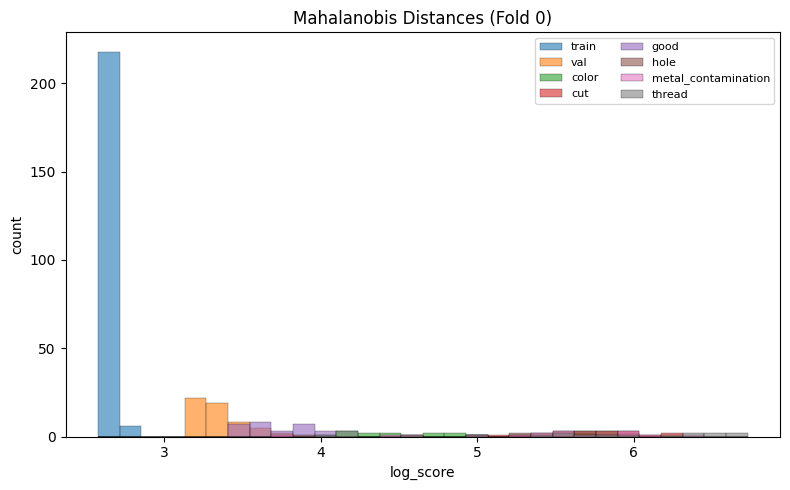

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_0_hist.png


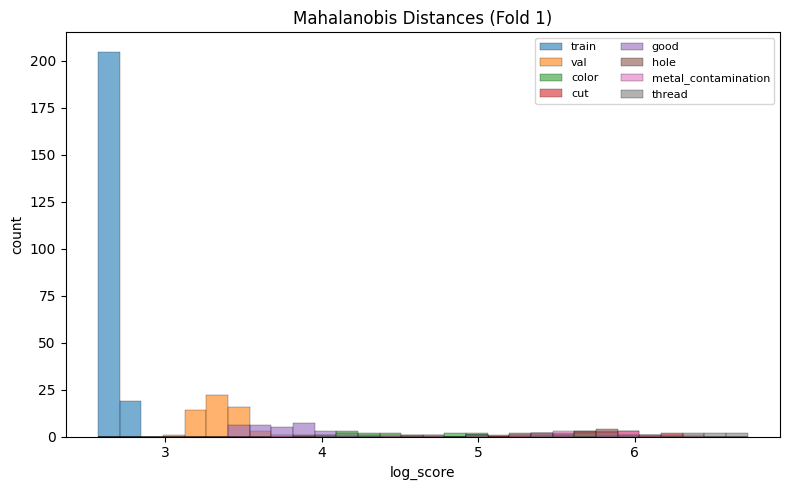

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_1_hist.png


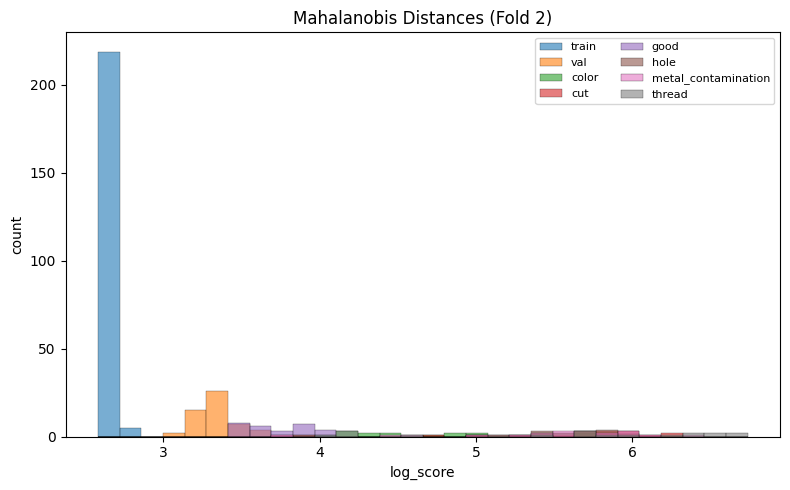

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_2_hist.png


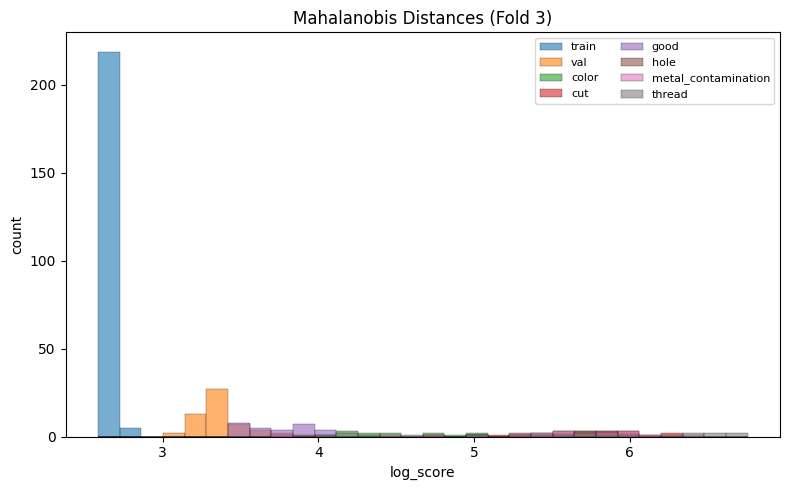

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_3_hist.png


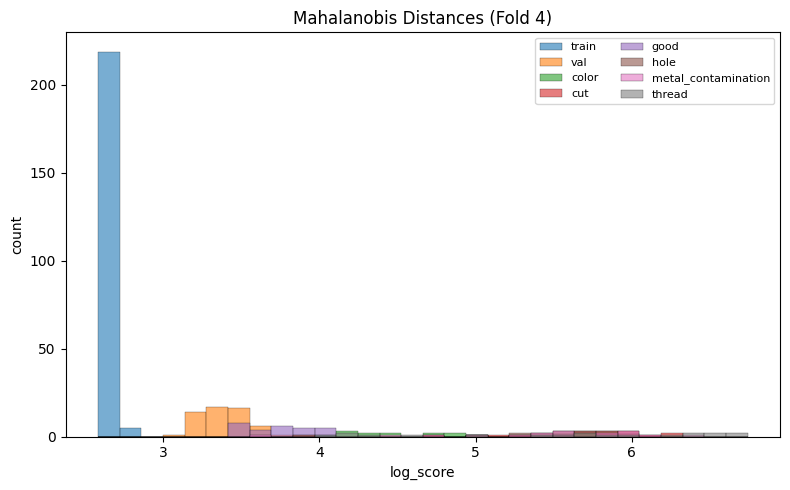

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_4_hist.png


In [ ]:
all_results_MD = {}
for ifold, fold in enumerate(cv_folds):
    model_state = fit_mahalanobis(fold["train_loader"], model, feature_node='features.8', device=device)
    scores_train = all_mahalanobis_scores(model_state, fold["train_loader"])
    scores_val = all_mahalanobis_scores(model_state, fold["val_loader"])
    scores_test = all_mahalanobis_scores(model_state, dev_test_loader)

    all_results_MD[ifold] = {
        "model_state": model_state,
        "scores_train": scores_train,
        "scores_val": scores_val,
        "scores_test": scores_test,
    }

    df_MD = pd.DataFrame({
        "score": np.r_[scores_train.numpy(), scores_val.numpy(), scores_test.numpy()],
        "label": (["train"] * len(scores_train) + ["val"] * len(scores_val) + dev_test_loader.dataset.labels),
    })

    plot_histogram(df_MD, ifold)

In [10]:
# 各フォールドのvalデータのスコアのFPR=1%点を計算
folds_results_MD = []
for ifold, results in all_results_MD.items():
    scores_val = results["scores_val"].numpy()
    scores_test = results["scores_test"].numpy()
    labels_val = np.array([0]*len(scores_val))  # valデータはすべて正常
    labels_test = np.array([0 if lbl == "good" else 1 for lbl in dev_test_loader.dataset.labels])  # testデータのラベル

    # valデータで閾値を決定（FPR=1%点）
    threshold = np.percentile(scores_val, 99)  # 上位1%を異常とする閾値

    # testデータでの異常検知結果を計算
    preds_test = (scores_test >= threshold).astype(int)

    # 評価指標を計算
    auc = roc_auc_score(labels_test, scores_test)
    f1 = f1_score(labels_test, preds_test)
    folds_results_MD.append({
        "fold": ifold,
        "threshold": threshold,
        "auc": auc,
        "f1": f1
    })
    print(f"[Fold {ifold}] Val threshold (FPR=1%): {threshold:.2f}, Test AUC: {auc:.4f}, F1: {f1:.4f}")
# AUC, F1 の平均と標準偏差を計算
aucs = [r["auc"] for r in folds_results_MD]
f1s = [r["f1"] for r in folds_results_MD]
print(f"[Mahalanobis] Test AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}, F1: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

# 保存（サマリーCSV: 各フォールド1行）
df_md_summary = pd.DataFrame(folds_results_MD)
csv_md = dir_md / 'summary.csv'
df_md_summary.to_csv(csv_md, index=False)
print(f'[INFO] Saved summary CSV: {csv_md}')


[Fold 0] Val threshold (FPR=1%): 41.44, Test AUC: 0.9904, F1: 0.9263
[Fold 1] Val threshold (FPR=1%): 35.61, Test AUC: 0.9904, F1: 0.9036
[Fold 2] Val threshold (FPR=1%): 44.66, Test AUC: 0.9900, F1: 0.9362
[Fold 3] Val threshold (FPR=1%): 51.06, Test AUC: 0.9896, F1: 0.9560
[Fold 4] Val threshold (FPR=1%): 44.07, Test AUC: 0.9888, F1: 0.9312
[Mahalanobis] Test AUC: 0.9898 ± 0.0006, F1: 0.9307 ± 0.0169
[INFO] Saved summary CSV: results/dev/20250915_111435/MD/summary.csv


### PaDiMでの異常検知実験

%load_ext autoreload
%autoreload 2

import importlib, sys
import anomaly_detectors  # パス確認
print("anomaly_detectors path:", anomaly_detectors)

importlib.invalidate_caches()
importlib.reload(anomaly_detectors)

##### 関数を再インポート（← これが大事）

from anomaly_detectors import fit_padim, padim_heatmap, all_padim_scores, fit_mahalanobis, all_mahalanobis_scores

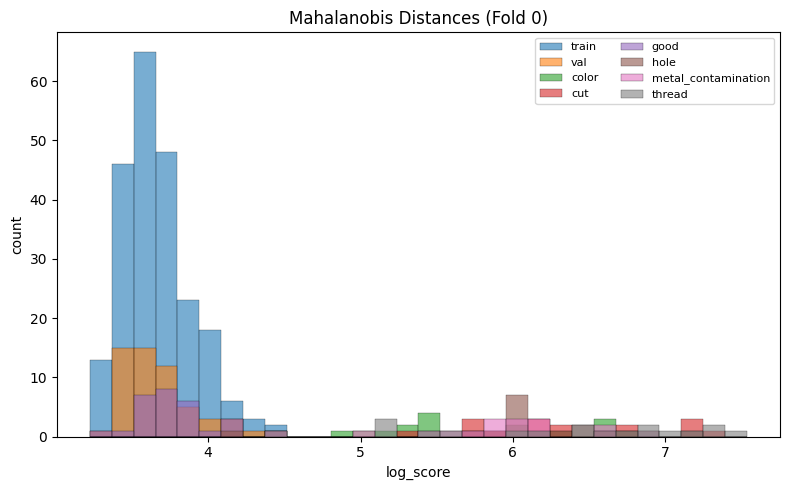

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_0_hist.png


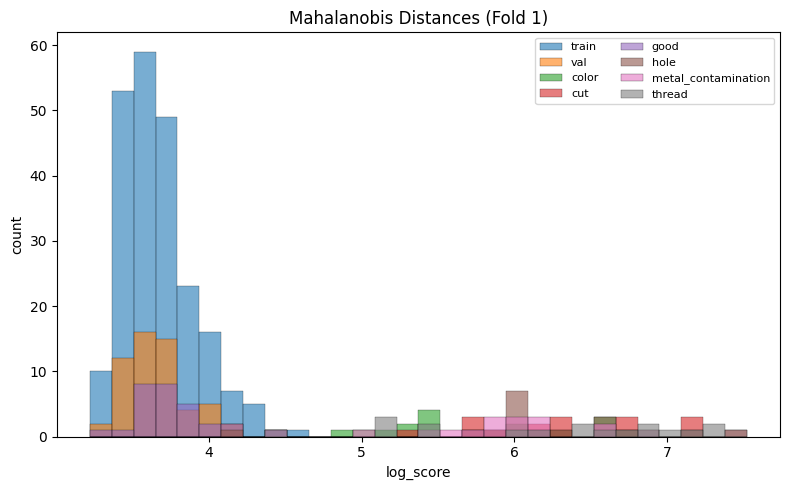

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_1_hist.png


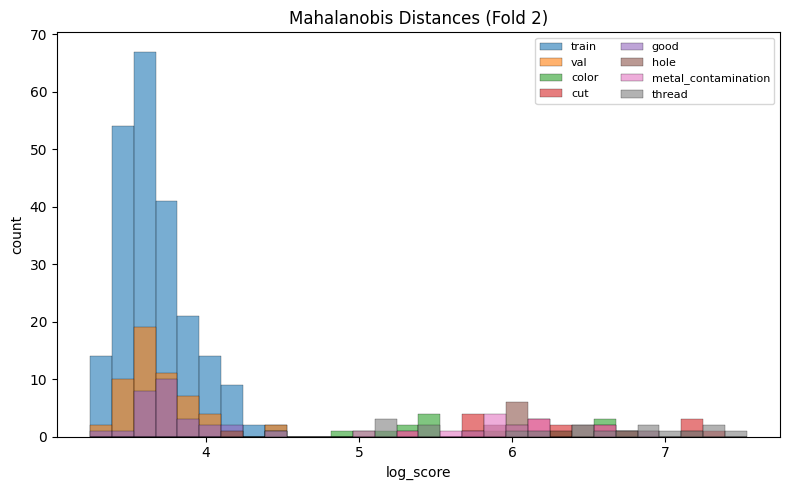

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_2_hist.png


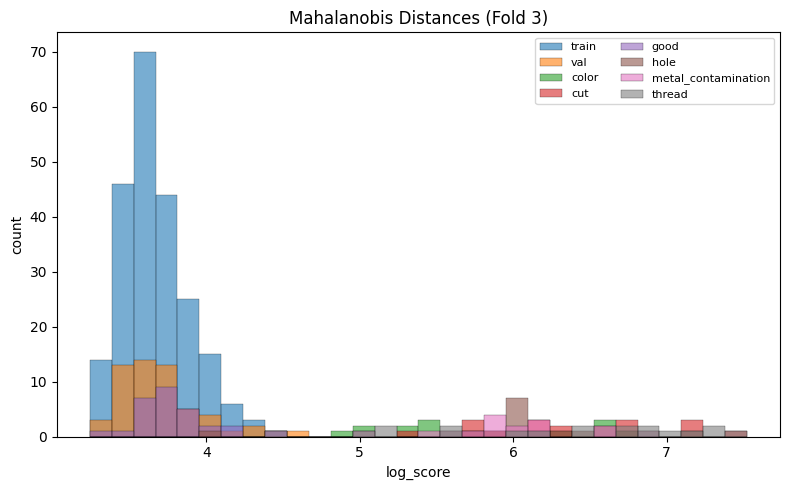

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_3_hist.png


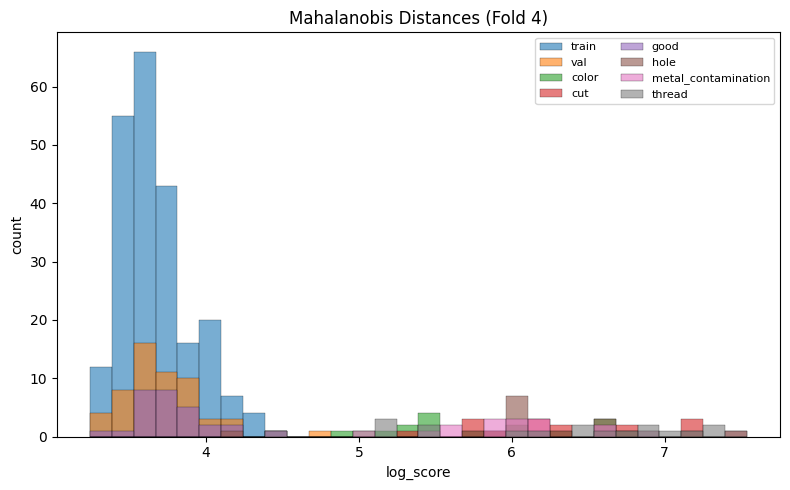

[INFO] Saved histogram PNG: results/dev/20250915_111435/MD/fold_4_hist.png


In [15]:
# CV 各フォールドで PaDiM を学習・評価
all_results_PaDiM = {}
for ifold, fold in enumerate(cv_folds):
    model_state = fit_padim(
        fold["train_loader"],
        model,
        layers=padim_layers,
        d=padim_channel_subsample,
        device=device
        )
    scores_train = all_padim_scores(model_state, fold["train_loader"])
    scores_val = all_padim_scores(model_state, fold["val_loader"])
    scores_test, heatmaps_test = all_padim_scores(model_state, dev_test_loader, return_maps=True)

    all_results_PaDiM[ifold] = {
        "model_state": model_state,
        "scores_train": scores_train,
        "scores_val": scores_val,
        "scores_test": scores_test,
        "heatmaps_test": heatmaps_test,
    }

    df_PaDiM = pd.DataFrame({
        "score": np.r_[scores_train.numpy(), scores_val.numpy(), scores_test.numpy()],
        "label": (["train"] * len(scores_train) + ["val"] * len(scores_val) + dev_test_loader.dataset.labels),
    })

    plot_histogram(df_PaDiM, ifold)


In [16]:
# 評価指標の算出
folds_results_PaDiM = []
for ifold, results in all_results_PaDiM.items():
    scores_val = results["scores_val"].numpy()
    scores_test = results["scores_test"].numpy()
    labels_val = np.zeros_like(scores_val)  # valは正常のみ
    labels_test = np.array([0 if lbl == "good" else 1 for lbl in dev_test_loader.dataset.labels])

    threshold = np.percentile(scores_val, 99)
    preds_test = (scores_test >= threshold).astype(int)
    auc = roc_auc_score(labels_test, scores_test)
    f1 = f1_score(labels_test, preds_test)
    folds_results_PaDiM.append({
        "fold": ifold,
        "threshold": threshold,
        "auc": auc,
        "f1": f1
    })
    print(
        f"[PaDiM Fold {ifold}] Val threshold (FPR=1%): {threshold:.4f}, "
        f"Test AUC: {auc:.4f}, F1: {f1:.4f}"
    )
# AUC, F1 の平均と標準偏差を計算
aucs = [r["auc"] for r in folds_results_PaDiM]
f1s = [r["f1"] for r in folds_results_PaDiM]
print(f"[PaDiM] Test AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}, F1: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

# 保存（サマリーCSV: 各フォールド1行）
df_p_summary = pd.DataFrame(folds_results_PaDiM)
csv_p = dir_p / 'summary.csv'
df_p_summary.to_csv(csv_p, index=False)
print(f'[INFO] Saved summary CSV: {csv_p}')


[PaDiM Fold 0] Val threshold (FPR=1%): 81.8580, Test AUC: 0.9984, F1: 0.9888
[PaDiM Fold 1] Val threshold (FPR=1%): 60.4683, Test AUC: 0.9984, F1: 0.9832
[PaDiM Fold 2] Val threshold (FPR=1%): 81.4801, Test AUC: 0.9984, F1: 0.9888
[PaDiM Fold 3] Val threshold (FPR=1%): 83.3298, Test AUC: 0.9980, F1: 0.9888
[PaDiM Fold 4] Val threshold (FPR=1%): 86.6128, Test AUC: 0.9980, F1: 0.9831
[PaDiM] Test AUC: 0.9982 ± 0.0002, F1: 0.9865 ± 0.0028
[INFO] Saved summary CSV: results/dev/20250915_111435/PaDiM/summary.csv


#### PaDiMのヒートマップ表示

In [17]:
def inv_transform(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """正規化済み画像テンソルを逆変換してNumPy配列にする"""
    # バッチ次元がある場合は除去
    if img_tensor.dim() == 4:
        img = img_tensor.squeeze(0)
    else:
        img = img_tensor

    # テンソルを NumPy 配列に変換（形状は [3, H, W]）
    img_np = img.cpu().numpy()

    # 逆正規化: 各チャネルについて (x * std + mean)
    mean = np.array(mean)[:, None, None]
    std = np.array(std)[:, None, None]
    img_np = img_np * std + mean

    # 値を [0, 1] にクリップ
    img_np = np.clip(img_np, 0, 1)

    # 軸の順番を [3, H, W] → [H, W, 3] に変換
    img_np = np.transpose(img_np, (1, 2, 0))

    return img_np

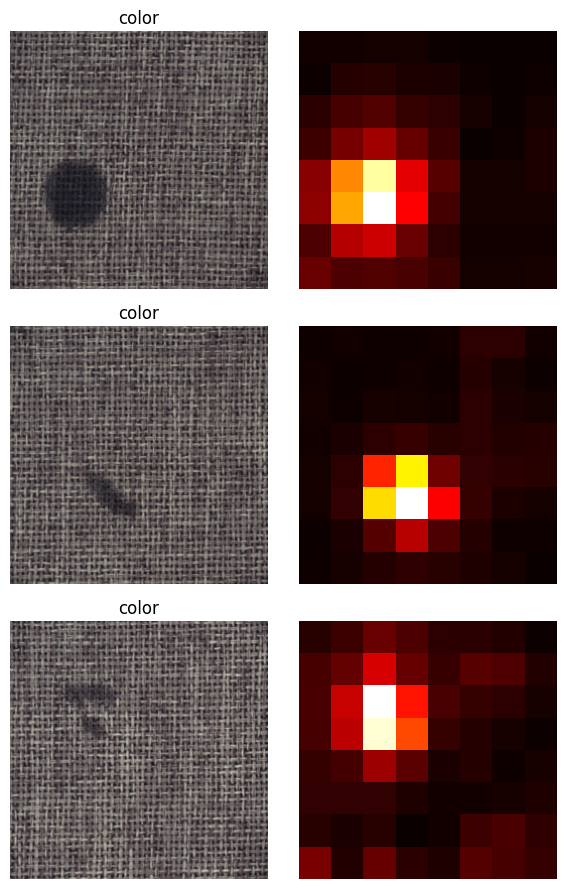

[INFO] Saved heatmaps: results/dev/20250915_111435/PaDiM/heatmaps_by_PaDiM.png


In [18]:
# テスト画像のヒートマップ表示（最初の3枚）
fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for i in range(3):
    img, lbl = dev_test_loader.dataset[i]
    heatmap = all_results_PaDiM[0]["heatmaps_test"][i].numpy()
    img = inv_transform(img)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(lbl)
    axes[i, 0].axis("off")
    axes[i, 1].imshow(heatmap, cmap="hot")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()
# 画像として保存（Fold 0 の最初3枚の可視化）
out_png = dir_p / 'heatmaps_by_PaDiM.png'
fig.savefig(out_png, dpi=150)
print(f'[INFO] Saved heatmaps: {out_png}')


## 設定の保存
出力先：assets/fixed_pipeline.json

In [19]:
# デフォルトではファイルを書き出さない（テンプレートのため）。
# 実際に保存したい場合は SAVE_FIXED=True にして実行してください。
SAVE_FIXED = True

fixed_pipeline = {
    "common": {"image_size": image_size, "seeds": seeds},
    #"algorithms": {"mahalanobis": use_mahalanobis, "padim": use_padim},
    "threshold": {"method": "percentile", "percentile": 99},
    "mahalanobis": {"backbone": backbone},# "cov_estimator": cov_estimator},
    "padim": {"backbone": backbone, "layers": padim_layers, "d": padim_channel_subsample}
}

assets_dir = Path("assets")
assets_dir.mkdir(parents=True, exist_ok=True)
cfg_path = assets_dir / "fixed_pipeline.json"

if SAVE_FIXED:
    with cfg_path.open("w", encoding="utf-8") as f:
        json.dump(fixed_pipeline, f, indent=2, ensure_ascii=False)
    print(f"[INFO] Saved: {cfg_path}")
else:
    print("[INFO] SAVE_FIXED=False のため assets 固定ファイルはスキップ。")

# 必須: 実行設定を timestamp 付き出力ディレクトリにも保存
cfg_out = base_dir / 'fixed_pipeline.json'
with cfg_out.open('w', encoding='utf-8') as f:
    json.dump(fixed_pipeline, f, indent=2, ensure_ascii=False)
print(f"[INFO] Saved config to: {cfg_out}")


[INFO] Saved: assets/fixed_pipeline.json
[INFO] Saved config to: results/dev/20250915_111435/fixed_pipeline.json


## 次の手順
- 上記のテンプレート関数に実装を追加し、dev の test から閾値を決めて `SAVE_FIXED=True` で JSON を保存。
- その後 `02_evaluation_report.ipynb` で eval カテゴリを一発評価。
- リーク防止のため、02 ではパラメータ・閾値を変更しないこと。
